# Introduction to Machine Learning in Python

Now that we've covered supervised learning for both classification and regression, let's take a look at unsupervised learning.

## Part 0: Preparing Data

We'll quickly repeat the data cleaning pipeline to get ready to start modeling.

In [1]:
import pandas as pd
import numpy as np
import random

In [2]:
## Load the data
listings_raw = pd.read_csv('../data/listings_with_amenities.csv')

In [3]:
def clean_price(p):
    p = p.replace('$','').replace(',','') # replace all '$' and ',', similar to in R
    return float(p)

listings_raw.loc[:,'price'] = listings_raw.loc[:,'price'].apply(lambda x: clean_price(x));

In [4]:
# We'll also clean up some outliers
listings_clean = listings_raw.query('accommodates <= 10 & price <= 1000')
listings_clean = listings_clean.query('maximum_nights <= 2000')

# Filter by property type
listings_clean = listings_clean[listings_clean['property_type'].isin(["Apartment", "House", "Bed & Breakfast", "Condominium", "Loft", "Townhouse"])]
listings_clean = listings_clean[~listings_clean['neighbourhood_cleansed'].isin(["Leather District", "Longwood Medical Area"])]

# Find columns with sufficient fill (at most 25% missing values)
cols_keep = listings_clean.columns[listings_clean.isnull().mean() <= 0.25]
listings_clean = listings_clean.loc[:,cols_keep]

# Let's one-hot encode our property types
listings_clean = pd.get_dummies(listings_clean, columns = ['property_type'], drop_first = True)

# We're also going to filter to numeric columns for now- 
# You can use one-hot encoding to handle categorical variables, but today we'll stick to this.
listings_clean = listings_clean.select_dtypes(include=np.number)

Let's impute the missing data - we will simply impute the mean. There are other options available in `sklearn.impute`.
Notice that the missingness is in numeric columns only, which makes it easier to deal with. If there are categoric columns with missing data, different approaches need to be taken (e.g. mode imputation).

In [5]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(listings_clean)

# Get the imputed values and convert back into a dataframe (it will return a matrix)
listings = pd.DataFrame(imp_mean.transform(listings_clean), 
                        columns = listings_clean.columns)

We'll start by defining our feature space. We'll only look at numeric features to keep things simple for now.

In [6]:
features = ['host_listings_count', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'price', 'guests_included',
       'minimum_nights', 'maximum_nights', 
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value',
       'reviews_per_month']

X = listings[features]

We also need to *standardize* the data. Clustering groups together observations by the disstance between them. If the features are on inconsistent scales, this leads "large" features to dominate the distance metric and thus cluster assignment. 

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
scaler.fit(X)
X_std = pd.DataFrame(scaler.transform(X), columns = X.columns)

### Choosing the optimal number of clusters

We can use the silhouette metric (SM), a measure of cluster quality, to select the optimal number of clusters. The Silhouette score for an individual observation is calculated as:
$$s(i) = \frac{b(i)-a(i)}{\max(b(i),a(i))}$$
where a(i) is the average distance from observation i to the other points in its cluster, and b(i) is the average distance from observation i to the points in the second closest cluster. 

The overall metric for the full cluster assignment averages the individual scores:
$$ SM = \frac{1}{n}\sum_{i=1}^n s(i) $$

SM is bounded by \[-1,1\], with 1 being the "best" score. We can plot SM against different $K$ values and select the cluster count $K$ that maximizes the sccore.  

In [11]:
from sklearn.metrics import silhouette_score

k_range = range(2, 11)
sil = []

for k in k_range:
  kmeans = KMeans(n_clusters = k).fit(X_std)
  labels = kmeans.labels_
  sil.append(silhouette_score(X_std, labels, metric = 'euclidean'))

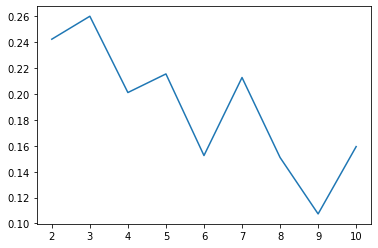

In [12]:
import matplotlib.pyplot as plt

plt.plot(k_range, sil)

$K=3$ gives the best Silhouette Metric, so we'll use this as our $K$ for $k$-means.

In [13]:
K = 3
kmeans = KMeans(n_clusters=K, random_state=0).fit(X_std)

X_withlabel = X.copy()
X_withlabel['cluster'] = kmeans.predict(X_std)

How can we interpret clusters? A simple approach is to look at the means of each feature to see if there are differentiating features.

In [14]:
X_withlabel.groupby('cluster').mean()

,host_listings_count,accommodates,bathrooms,bedrooms,beds,price,guests_included,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
cluster,,,,,,,,,,,,,,,,,,
0,119.003509,2.526316,1.152065,1.011384,1.333909,137.291228,1.157895,4.052632,806.350877,15.592982,72.814035,7.715789,7.112281,8.410526,8.452632,8.536842,7.308772,1.245965
1,32.383712,2.329011,1.086664,0.952269,1.231561,135.250405,1.192058,3.061183,813.025932,20.859806,93.716637,9.606801,9.449556,9.779880,9.773251,9.500470,9.364225,2.117438
2,128.482574,5.384718,1.638351,2.300268,2.836461,288.471850,2.245308,3.253351,894.643432,14.843164,93.261020,9.516019,9.444487,9.685029,9.690362,9.466897,9.243326,1.792815


What do we notice here?.
- Cluster 0 seems to be comprised of "mega"-hosts with low-end units: cheap, 1 bedroom units, with very low reviews. 
- Cluster 1 has smaller units with smaller-scale hosts, and generally high reviews.
- Cluster 2 has "mega"-hosts with high capacity (and higher prices). This seems like units oriented towards groups.

### References
- Silhouette metric for selection of K ([medium](https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb))